<a href="https://colab.research.google.com/github/ykato27/Image-Classification/blob/main/3_7_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Residual Networks の実装

Implementation of Resudual Networks

注：このページは必ず GPU で実行してください．

Note: This page must be run on a GPU.

### Resブロック

このページで作成する小ブロックの構成は
```
入力 (Add) --- BatchNorm --- Activation --- Conv ---- BatchNorm --- Activation --- Conv
     |                                                                             |
     ---------------------------------------------------------------------------- Add --- 出力
```
というものです．
これは [K. He, X. Zhang, S. Ren, and J. Sun., Identity mappings in deep residual networks, In Proc. of ECCV (2016)]で提案されたもので，バッチ正規化と活性化関数を入れる場所がオリジナルのもの異なります．

The structure of the small block to be created in this page is as above. This was proposed in [K. He, X. Zhang, S. Ren, and J. Sun., Identity mappings in deep residual networks, In Proc. of ECCV (2016)].
The locations for batch normalization and activation functions are different from the original.

#### データ増大（変形）用モジュールの読み込み

Loading modules for data augmentation (transformation)

In [ ]:
!git clone https://github.com/yu4u/cutout-random-erasing ./random_eraser 
                                                      #github から cutout-random-erasingh を random_eraser にコピー

import sys
sys.path.append("/content/random_eraser/")  #モジュールのあるディレクトリを直接指定してパスを通す

Cloning into './random_eraser'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 30 (delta 0), reused 1 (delta 0), pack-reused 26
Unpacking objects: 100% (30/30), done.


### ResNet を生成する関数の定義 

Definition of a function to generate ResNet 


Keras では ResNet のように枝分かれを持つネットワークの構成には，Sequential ではなく，Model というクラスを使います．

基本的には

```
input = Input(shape=(32, 32, 3), dtype=tf.float32))
X = input
X1 = Layer1()(X)
X2 = Layer2()(X)
y = Add()([X1, X2])
model = Model(inputs=[input], outputs=[y])
```

などとすると，一度枝分かれしてから合流するネットワークモデルのインスタンスが生成されます．ここで，`Layer1()` や `Layer2()` は何らかの層であり，`Add()` は引数のリストの中身を足し算する層です．

Keras uses a class called Model instead of Sequential to construct a network with branches like ResNet ,which cab be used as above.
Here, `Layer1()` and `Layer2()` are layers of some kind, and `Add()` is a layer that adds up the contents of a list of arguments.


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Add, BatchNormalization, Activation, MaxPooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential

'''
ResNet18: nb_blocks = [2,2,2,2], wide = 2, nottleneck = False
ResNet34: nb_blocks = [3,4,6,3], wide = 2, nottleneck = False
ResNet50: nb_blocks = [3,4,6,3], wide = 2, nottleneck = True
ResNet101: nb_blocks = [3,4,23,3], wide = 2, nottleneck = True
ResNet152: nb_blocks = [3,8,36,3], wide = 2, nottleneck = True
WideResNet: nb_blocks = [3,3,3], wide >= 3, nottleneck = False  
'''

def resnet(nb_blocks = [3,4,6,3], wide = 2, bottleneck = False):
  '''
  引数
  nb_blocks  : 大きなブロックの中にあるResブロックの数のリスト
  wide       : 大きなブロックから次の大きなブロックに進むときにチャンネル数を何倍にするか（デフォルトは2）
  bottleneck : True なら bottleneck 構造，False なら 普通のResブロック
  '''
  input = Input(shape=(32, 32, 3), dtype=tf.float32)
  X = input
  n_filter = 64
  X = Conv2D(n_filter, (3,3),  padding="same",kernel_initializer='he_normal')(X)
   
  shortcut = X
  X = BatchNormalization()(X)
  
  if bottleneck == False:
  
    for i, repete in enumerate(nb_blocks):
      for j in range(repete):     
        if i>0 and j == 0:
          shortcut =  Conv2D(n_filter, (1, 1), strides=(2, 2),
                            kernel_initializer='he_normal')(shortcut)
          X = Activation("relu")(X)
          X = Conv2D(n_filter, (3,3), strides= (2,2), padding="same", kernel_initializer='he_normal')(X)
          X = BatchNormalization()(X)
        
        else:      
          X = Activation("relu")(X)
          X = Conv2D(n_filter, (3,3), padding="same", kernel_initializer='he_normal')(X)
          X = BatchNormalization()(X)
      
        X = Activation("relu")(X)
        X = Conv2D(n_filter, (3,3), padding="same",kernel_initializer='he_normal')(X)
      
        
        # ショートカットとマージ
        X = Add()([X, shortcut])
        shortcut = X
        X = BatchNormalization()(X)
      n_filter *= wide
  
  if bottleneck == True:
    shortcut =  Conv2D(n_filter * 4, (1, 1), kernel_initializer='he_normal')(shortcut)  
    
 
    for i, repete in enumerate(nb_blocks):
      for j in range(repete):
        if i>0 and j == 0:
          shortcut =  Conv2D(n_filter * 4, (1, 1), strides=(2, 2),
                            kernel_initializer='he_normal')(shortcut)
          X = Activation("relu")(X)
          X = Conv2D(n_filter, (1,1), strides= (2,2), padding="same", kernel_initializer='he_normal')(X)
          X = BatchNormalization()(X)
        
        else:
          X = Activation("relu")(X)
          X = Conv2D(n_filter, (1,1), padding="same", kernel_initializer='he_normal')(X)
          X = BatchNormalization()(X)
      
       
        X = Activation("relu")(X)
        X = Conv2D(n_filter, (3,3), padding="same",kernel_initializer='he_normal')(X)
        X = BatchNormalization()(X)
        X = Activation("relu")(X)
        X = Conv2D(n_filter * 4, (1,1), padding="same",kernel_initializer='he_normal')(X)
        
        # ショートカットとマージ
        X = Add()([X, shortcut])
        shortcut = X
        X = BatchNormalization()(X)
      n_filter *= wide

  
  # 全結合
  X = Activation("relu")(X)
  X = GlobalAveragePooling2D()(X)
  X = Dropout(0.5)(X)
  y = Dense(10, activation="softmax")(X)
  # モデル
  model = Model(inputs=[input], outputs=[y])
  return model


#### Cifar-10 の読み込み，データ増大の設定，ネットワークモデルの生成とコンパイル

 Loading Cifar-10, setting up data augmentation, generating and compiling network models

In [ ]:
import tensorflow.keras.backend as K

K.clear_session()

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from random_eraser import get_random_eraser # https://github.com/yu4u/cutout-random-erasing 
import os
from tensorflow.keras.optimizers import Adam


# CIFAR
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
x_train, x_test = (X_train / 255.0), (X_test / 255.0)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)  

#データ増大の設定
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=2.0,  # set range for random shear
            zoom_range=0.1,  # set range for random zoom
            channel_shift_range=0,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function = get_random_eraser(p=0.5, s_l=0.02, s_h=0.1, r_1=0.3, r_2=1/0.3, v_l=0, v_h=0),
            # image data format, either "channels_first" or "channels_last"
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

# モデルを作成
#original residual network
model = resnet(nb_blocks = [2,2,2,2], wide = 2, bottleneck = False)

# モデルをコンパイル
model.compile( Adam(lr=1e-3), loss="categorical_crossentropy", 
              metrics=["acc"])


170508288/170498071 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### モデルの構造を可視化する．

Visualizing the model structure.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

最後のまとめを見ると，比較手小規模な ResNet18 ですら 11,184,778 個のパラメータを持つことが分かります．

The final summary shows that even the relatively small ResNet18 has 11,184,778 parameters.

ネットワークのグラフを見るには以下のようにします．

To see the graph of the network, do the following.

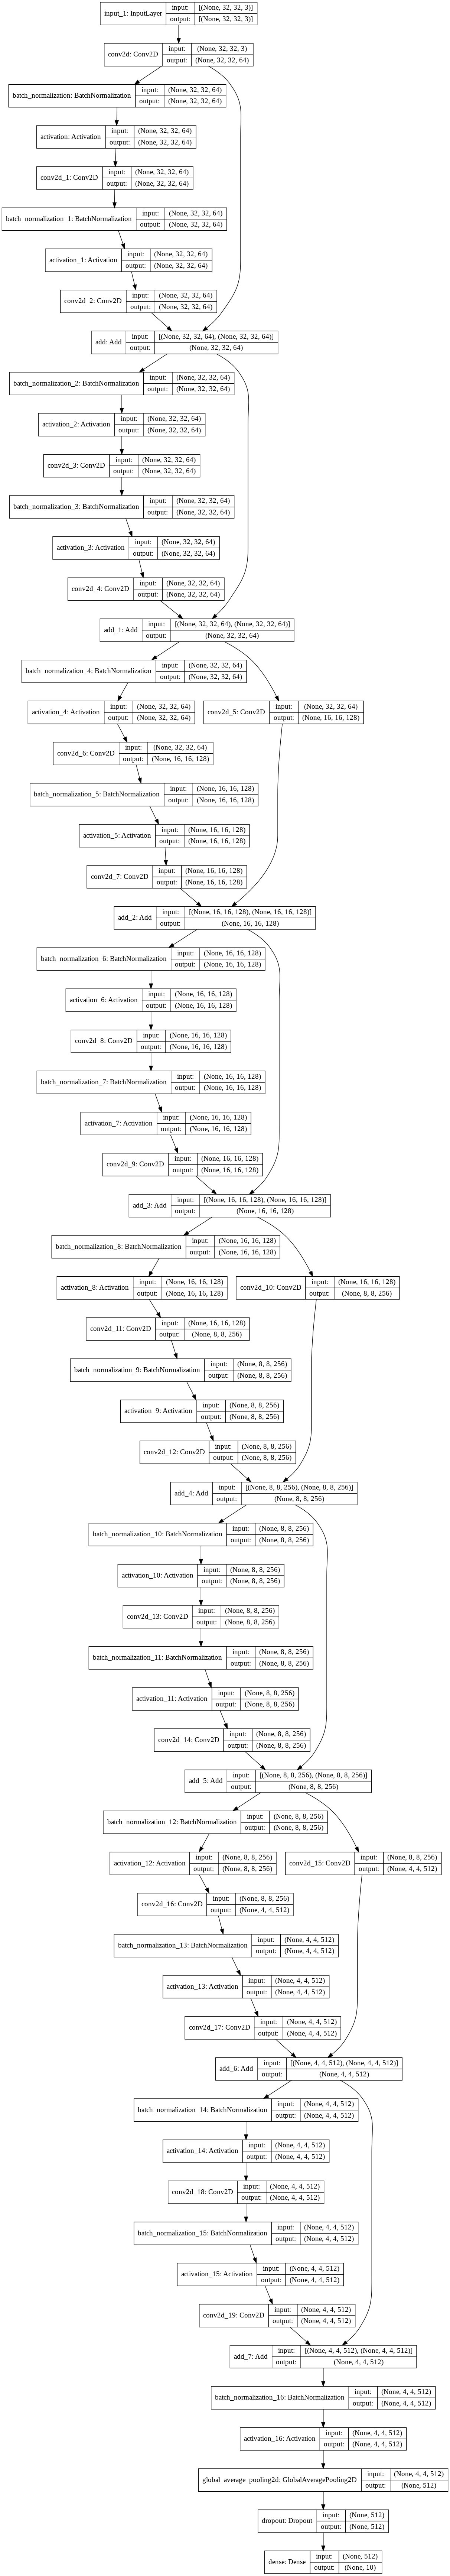

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes = True)

#### 学習の実行

（時間がかかるので「学習済みパラメータの読み込み」まで進んでも構いません）

スケジューラを使って学習係数を変えながら50エポック計算してみます．

Running the training

(It will take some time, so you may proceed to "Load Trained Parameters")

We will use the scheduler to calculate 50 epochs with different learning coefficients.

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

#schedulerの設定
def step_decay(epoch):
    x = 0.001
    if epoch >= 20: x = 0.0003
    if epoch >= 35: x = 0.0001
    return x
decay = LearningRateScheduler(step_decay, verbose=1)
#datagen.fit(X_train)
#validationgen.fit(x_test)


#データ増大と学習率の変更をしない場合
#history = model.fit(x_train, y_train, batch_size=128, epochs = 10, verbose=1,validation_data=(x_test,y_test))

#データ増大と学習率の変更をする場合
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128), 
                              steps_per_epoch=len(x_train) // 128, epochs=50, validation_data=(x_test,y_test),
                              workers=8, use_multiprocessing=True, #これを指定するとイメージジェネレーターを並列にやってくれる
                              callbacks=[decay])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 143s 274ms/step - loss: 1.5452 - acc: 0.4364 - val_loss: 2.3147 - val_acc: 0.3896
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 105s 268ms/step - loss: 1.0879 - acc: 0.6096 - val_loss: 0.9304 - val_acc: 0.6763
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 105s 268ms/step - loss: 0.8780 - acc: 0.6907 - val_loss: 0.8425 - val_acc: 0.7194
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 105s 268ms/step - loss: 0.7447 - acc: 0.7401 - val_loss: 0.8224 - val_acc: 0.7185
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 105s 267ms/step - loss: 0.6542 - acc: 0.7734 - val_loss: 0.745

テストデータに対する精度が92%となりました．

The accuracy for the test data was 92%.

In [ ]:
import matplotlib.pyplot as plt


train_acc = history.history['acc']
test_acc = history.history['val_acc']
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train accuracy')
plt.plot(x, test_acc, label = 'test accuracy')
plt.legend() #グラフの線の説明を表示


与えられたデータに対
する予測は


```
model.predict(データセット).argmax(axis = 1))
```

でできます．`argmax(axis = 1))`は10次元ベクトルから0から9の分類値に変換する関数です．

The prediction for a given data can be done by teh above code,
where the function `argmax(axis = 1))` converts a 10-dimensional vector to a classification value from 0 to 9.



In [ ]:
print('Predicts are \n',model.predict(x_test[0:50]).argmax(axis = 1))
print('The correct values are \n', y_test[0:50].argmax(axis = 1))

学習結果のセーブ Save the tarining result.

In [ ]:
model.save_weights('ResNet18_weights.h5')

学習結果のロード Loading the training result.

In [ ]:
model.load_weights('ResNet18_weights.h5')

**学習済みモデルのパラメータの読み込み**

「ネットワークモデルの生成とコンパイル」のあと，あらかじめ学習済みのモデルの重みをダウンロードして読み込むこともできます．次のセルでダウンロードする重みは100エポック学習して得たものです．

After "Generate and compile a network model", you can also download and load the weights of a previously trained model. The weights to be downloaded in the next cell are those obtained after 100 epochs of training.

In [ ]:
#ダウンロード
import os
if not os.path.exists('ResNet18_weights.h5'):
  !wget 'http://www2.kaiyodai.ac.jp/~takenawa/learning/model/ResNet18_weights.h5'

#ウェイトの読み込み
model.load_weights('ResNet18_weights.h5')

テストデータを用いてモデルを評価

Evaluation of the model using test data

In [ ]:
model.evaluate(x_test, y_test)

テストデータに対する精度が93.12%であることが分かります．

We can see that the accuracy for the test data is 93.12%.

## Wide ResNet

ResNetは層を深くする（積み重ねる）ことで性能を上げようというものでしたが，それ程深くないネットワークでもチャンネルを増やすことで性能を上げようという考えで考案されたのが Wide ResNet です．（Zagoruyko-Komodakis, "Wide Residual Networks", https://arxiv.org/abs/1605.07146 ）

オリジナルの論文では，大きなブロックごとのチャンネル数を
$$16  \mbox{ -- } 16\times k   \mbox{  -- } 32\times k  \mbox{  --  } 64 \times k$$**としてとしていますが，本ページでは，**
$$64  \mbox{ -- } 64   \mbox{  -- } 64\times {\rm wide}  \mbox{  --  } 64 \times {\rm wide}^2$$
としています．

ResNet was designed to increase performance by increasing the number of layers, but Wide ResNet was designed to increase performance by increasing the number of channels in a network that is not so deep. (Zagoruyko-Komodakis, "Wide Residual Networks", https://arxiv.org/abs/1605.07146 )


In the original paper, the number of channels per large block was set to be $$16\mbox{ -- } 16\times k\mbox{ -- } 32\times k\mbox{ -- } 64\times k,$$
in this page, we set it as
$$64 \mbox{ -- } 64\mbox{ -- } 64\times {\rm wide} \mbox{ -- } 64\times {\rm wide}^2$$.


次のセルでワイド ResNet のモデルが作れますが，その前にこのページの最初の2つのコードを実行しておいてください．

The next cell creates a wide ResNet model, but before doing so, please run the first two codes on this page.

In [ ]:
import tensorflow.keras.backend as K

K.clear_session()

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from random_eraser import get_random_eraser # https://github.com/yu4u/cutout-random-erasing 
import os
from tensorflow.keras.optimizers import Adam


# CIFAR
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
x_train, x_test = (X_train / 255.0), (X_test / 255.0)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)  

datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            zca_epsilon=1e-06,  # epsilon for ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            shear_range=2.0,  # set range for random shear
            zoom_range=0.1,  # set range for random zoom
            channel_shift_range=0,  # set range for random channel shifts
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            cval=0.,  # value used for fill_mode = "constant"
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False,  # randomly flip images
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function = get_random_eraser(p=0.5, s_l=0.02, s_h=0.1, r_1=0.3, r_2=1/0.3, v_l=0, v_h=0),
            # image data format, either "channels_first" or "channels_last"
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

# モデルを作成
#wide resudual network
model = resnet(nb_blocks = [3,3,3], wide = 4)
model.compile( Adam(lr=1e-3), loss="categorical_crossentropy", 
              metrics=["acc"])


学習済みモデルのパラメータの読み込み

Loading teh pretrained model paraemeters

In [ ]:
#ダウンロード
import os
if not os.path.exists('WideResNet4_weights.h5'):
  !wget 'http://www2.kaiyodai.ac.jp/~takenawa/learning/model/WideResNet4_weights.h5'


#ウェイトの読み込み
model.load_weights('WideResNet4_weights.h5')

テストデータを用いてモデルを評価

Evaluation of the model using test data

In [ ]:
model.evaluate(x_test, y_test)

テストデータに対する精度は 94.41%となっています．

The accuracy for the test data is 94.41%.

In [ ]:
predict = model.predict(x_test[0:100]).argmax(axis = 1)
label = y_test[0:100].argmax(axis = 1)
print('Predicts are \n', predict)
print('The correct values are \n', label)
print( predict-label )


テストデータの最初の1000枚から誤っている画像のみ表示させてみる

Displaying only the wrongly predicted images from the first 1000 of the test data.

In [ ]:
import cv2
#サポートバッチのインポート
from google.colab.patches import cv2_imshow

def show_imgs(imgs):
  # imgs: 表示させる画像のデータセット 
  imgs_num = len(imgs) #画像の数
  row_num = np.ceil(imgs_num/4).astype('int8')#行数
  for i in range(row_num):
    row_images =[]
    for j in range(4):
      if 4*i+j < imgs_num:
        resized_image = cv2.resize(imgs[4*i+j][:,:,::-1],(64,64), interpolation=cv2.INTER_AREA)
        row_images.append(resized_image)
    row_images = np.concatenate(np.array(row_images), axis=1)
    cv2_imshow(row_images*255.0)


In [ ]:
categories = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
num_testing = 1000

predict = model.predict(x_test[0:num_testing ]).argmax(axis = 1)
label = y_test[0:num_testing ].argmax(axis = 1)
imgs = []
for i,v in enumerate(predict):
  ans = label[i]
  if v != ans:
    imgs += [x_test[i]]
    print('NG photo number:', i,', predict: ', categories[v], ', correct: ',  categories[ans])

show_imgs(imgs)
    

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes = True)

**学習**

大変に時間がかかります．

Learning

It takes a lot of time.

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

#schedulerの設定
def step_decay(epoch):
    x = 0.001
    if epoch >= 20: x = 0.0003
    if epoch >= 35: x = 0.0001
    return x
decay = LearningRateScheduler(step_decay, verbose=1)
#datagen.fit(X_train)
#validationgen.fit(x_test)


#データ増大と学習率の変更をしない場合
#history = model.fit(x_train, y_train, batch_size=128, epochs = 10, verbose=1,validation_data=(x_test,y_test))

#データ増大と学習率の変更をする場合
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128), 
                              steps_per_epoch=len(x_train) // 128, epochs=50, validation_data=(x_test,y_test),callbacks=[decay])


train_acc = history.history['acc']
test_acc = history.history['val_acc']
x = np.arange(len(train_acc))
plt.plot(x, train_acc, label = 'train accuracy')
plt.plot(x, test_acc, label = 'test accuracy')
plt.legend() #グラフの線の説明を表示
